Подключение библиотек

In [1]:
# === Базовые библиотеки ===

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# === Загрузка данных ===
import yfinance as yf

# === Анализ временных рядов ===
from statsmodels.tsa.stattools import adfuller

# === Машинное обучение ===
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, precision_recall_curve



from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# === Визуализация ===
import matplotlib.dates as mdates

# === Прочее (по необходимости) ===
import itertools
import math
import sys


import pickle



Сбор данных

In [2]:
# Загрузка данных по акциям Apple за 5 лет
apple_data = yf.download(
    tickers="AAPL",
    period="5y",  # Период: 5 лет
    interval="1d",  # Интервал: daily (дневные данные)
    auto_adjust=False  # Получить все колонки, включая Open, High, Low, Close, Volume
)

# Сброс индекса для преобразования Date в колонку
apple_data = apple_data.reset_index()

# Выбор нужных колонок
dataset = apple_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume']]

# Вывод первых 5 строк для проверки
print(dataset.head())

# Сохранение в CSV файл (опционально)
dataset.to_csv("AAPL_5y.csv", index=False)

[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open     Volume
Ticker                   AAPL        AAPL        AAPL        AAPL       AAPL
0      2020-11-09  116.320000  121.989998  116.050003  120.500000  154515300
1      2020-11-10  115.970001  117.589996  114.129997  115.550003  138023400
2      2020-11-11  119.489998  119.629997  116.440002  117.190002  112295000
3      2020-11-12  119.209999  120.529999  118.570000  119.620003  103162300
4      2020-11-13  119.260002  119.669998  117.870003  119.440002   81581900


Проверка на пропуски

In [3]:
# Функция проверки пропусков
def check_missing(df):
    total = len(df)
    df = df.replace(r'^\s*$', pd.NA, regex=True)
    missing_counts = df.isna().sum()
    
    report = pd.DataFrame({
        'column': missing_counts.index,
        'missing_count': missing_counts.values,
        'missing_pct': (missing_counts.values / total * 100)
    })
    return report
df = pd.read_csv("AAPL_5y.csv")
print("Пропуски в данных:\n", check_missing(df))

Пропуски в данных:
    column  missing_count  missing_pct
0    Date              0          0.0
1   Close              0          0.0
2    High              0          0.0
3     Low              0          0.0
4    Open              0          0.0
5  Volume              0          0.0


Перевод к вещественному типу данных

In [4]:
def read_and_clean_prices(path, cols=('Open','High','Low','Close'), sep=',', decimal=None):
    if decimal is not None:
        df = pd.read_csv(path, sep=sep, decimal=decimal)
        # Если columns могли быть прочитаны как object, явно привести
        for c in cols:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce')
        return df

    # При неизвестном формате читаем как строки для указанных колонок
    dtype_map = {c: 'object' for c in cols if c is not None}
    df = pd.read_csv(path, sep=sep, dtype=dtype_map)

    for c in cols:
        if c not in df.columns:
            continue
        # Убираем пробелы, заменяем запятую на точку, удаляем прочие символы кроме цифр, точки и минуса
        df[c] = (df[c]
                 .astype(str)
                 .str.strip()
                 .str.replace(r'\s+', '', regex=True)
                 .str.replace(',', '.', regex=False)
                 .str.replace(r'[^\d\.\-]', '', regex=True)
                )
        df[c] = pd.to_numeric(df[c], errors='coerce')

    return df

# Пример использования
df = read_and_clean_prices('AAPL_5y.csv', sep=',', decimal=None)
print(df[['Open','High','Low','Close']].dtypes)
# По желанию сохранить результат
df.to_csv('AAPL_5y.csv', index=False)

Open     float64
High     float64
Low      float64
Close    float64
dtype: object


Визуализация цены закрытия акций на графике

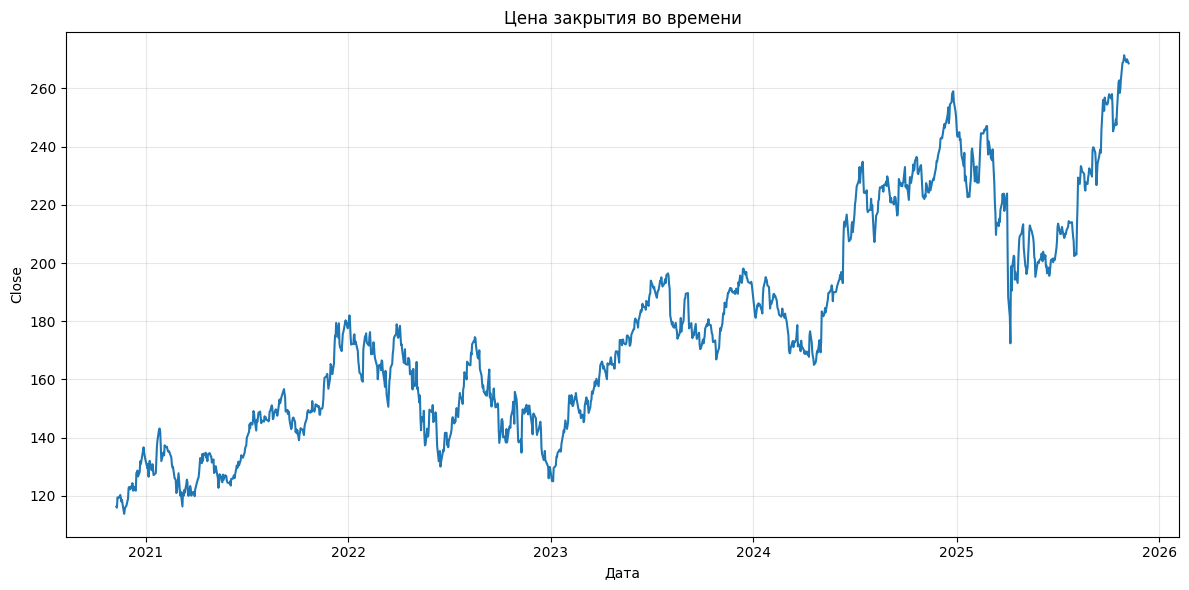

In [5]:

# Преобразуем Date в datetime, если нужно
df['Date'] = pd.to_datetime(df['Date'])

# Убедимся, что данные отсортированы по дате
df = df.sort_values('Date')

# Построение
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], marker='', linewidth=1.5, color='tab:blue')
plt.title('Цена закрытия во времени')
plt.xlabel('Дата')
plt.ylabel('Close')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Видно, что временной ряд нестационарен так как на нем видно тренд растущий вверх

Создание целевой перемены target. С помощью нее получится узнать когда акции росли, а когда падали в цене.

In [6]:
def add_targets(df, close_col='Close'):
    """
    Добавляет в df столбцы:
    - Target: 1 если Close[t] > Close[t-1], иначе 0
    """
    df = df.copy()
    if close_col not in df.columns:
        raise ValueError(f"Нет колонки '{close_col}' в DataFrame")

    # Направление: 1 если выросло по сравнению с предыдущей строкой, иначе 0
    df['Target'] = (df[close_col] > df[close_col].shift(1)).astype(int)
    return df

# Применение
df_with_targets = add_targets(pd.read_csv('AAPL_5y.csv'))
df_with_targets.to_csv('AAPL_5y.csv', index=False) 


Проверка на дисбаланс классов

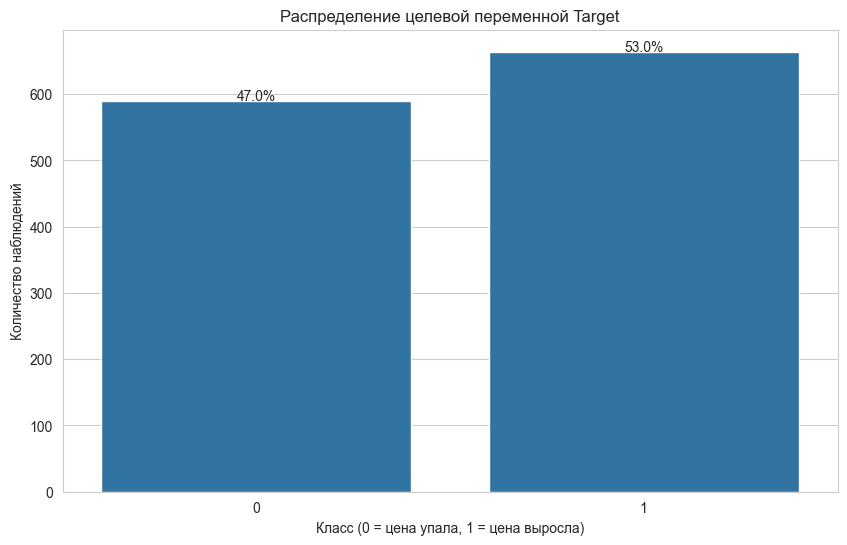

Распределение классов:
Класс 0 (цена упала или не изменилась): 590 наблюдений (47.05%)
Класс 1 (цена выросла): 664 наблюдений (52.95%)


In [7]:

# Устанавливаем стиль графиков
sns.set_style("whitegrid")

# Создаем график
plt.figure(figsize=(10, 6))

df = pd.read_csv('AAPL_5y.csv')

# Строим гистограмму распределения целевой переменной
ax = sns.countplot(x='Target', data=df)
plt.title('Распределение целевой переменной Target')
plt.xlabel('Класс (0 = цена упала, 1 = цена выросла)')
plt.ylabel('Количество наблюдений')

# Добавляем проценты на столбцы
total = len(df['Target'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.01
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

# Считаем точное распределение классов
class_counts = df['Target'].value_counts()
class_percentages = df['Target'].value_counts(normalize=True) * 100

print("Распределение классов:")
print(f"Класс 0 (цена упала или не изменилась): {class_counts[0]} наблюдений ({class_percentages[0]:.2f}%)")
print(f"Класс 1 (цена выросла): {class_counts[1]} наблюдений ({class_percentages[1]:.2f}%)")

Проверка на стационарность временного ряда

In [8]:

# Проводим тест Дики-Фуллера на столбце 'Close'
result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

"""Если p-value > 0.05, ряд нестационарный. Это значит его нужно дифференцировать."""

ADF Statistic: -1.0042919587450023
p-value: 0.7516956907257968
Critical Values: {'1%': np.float64(-3.4355838322867998), '5%': np.float64(-2.863851267837805), '10%': np.float64(-2.5680005460145554)}


'Если p-value > 0.05, ряд нестационарный. Это значит его нужно дифференцировать.'

In [9]:
df = pd.read_csv("AAPL_5y.csv")
df['Close_diff'] = df['Close'].diff()

In [10]:
df.head(5)

,Date,Close,High,Low,Open,Volume,Target,Close_diff
0,2020-11-09,116.320000,121.989998,116.050003,120.500000,154515300,0,NaN
1,2020-11-10,115.970001,117.589996,114.129997,115.550003,138023400,0,-0.349998
2,2020-11-11,119.489998,119.629997,116.440002,117.190002,112295000,1,3.519997
3,2020-11-12,119.209999,120.529999,118.570000,119.620003,103162300,0,-0.279999
4,2020-11-13,119.260002,119.669998,117.870003,119.440002,81581900,1,0.050003


ADF Statistic: -33.93683959566769
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4355838322867998), '5%': np.float64(-2.863851267837805), '10%': np.float64(-2.5680005460145554)}


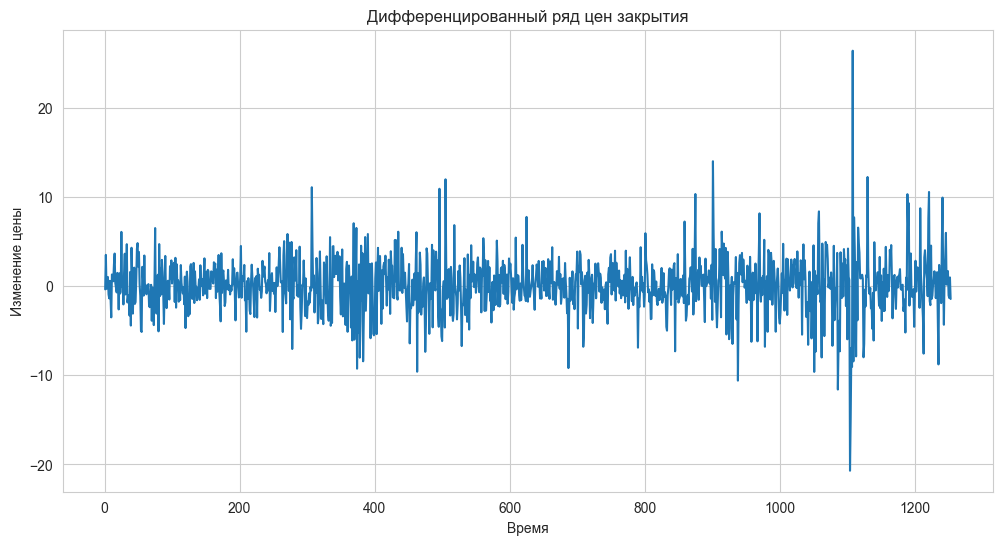

In [11]:
# # УДАЛЯЕМ пропущенные значения (первую строку)
df_diff = df['Close_diff'].dropna()

# Проводим тест Дики-Фуллера на очищенных данных
result = adfuller(df_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

df.to_csv("AAPL_5y.csv")    

# Визуализируем дифференцированный ряд для проверки
plt.figure(figsize=(12,6))
plt.plot(df_diff)
plt.title('Дифференцированный ряд цен закрытия')
plt.xlabel('Время')
plt.ylabel('Изменение цены')
plt.show()

In [12]:

# Проверка на наличие бесконечных значений
print("Наличие inf в данных:", np.any(np.isinf(df['Close_diff'])))

# Если есть inf, нужно их обработать
if np.any(np.isinf(df['Close_diff'])):
    # Заменить inf на NaN
    df['Close_diff'] = df['Close_diff'].replace([np.inf, -np.inf], np.nan)
    # Затем удалить NaN
    df_diff = df['Close_diff'].dropna()

df.to_csv("AAPL_5y.csv")

Наличие inf в данных: False


Визуализация стационарного ряда

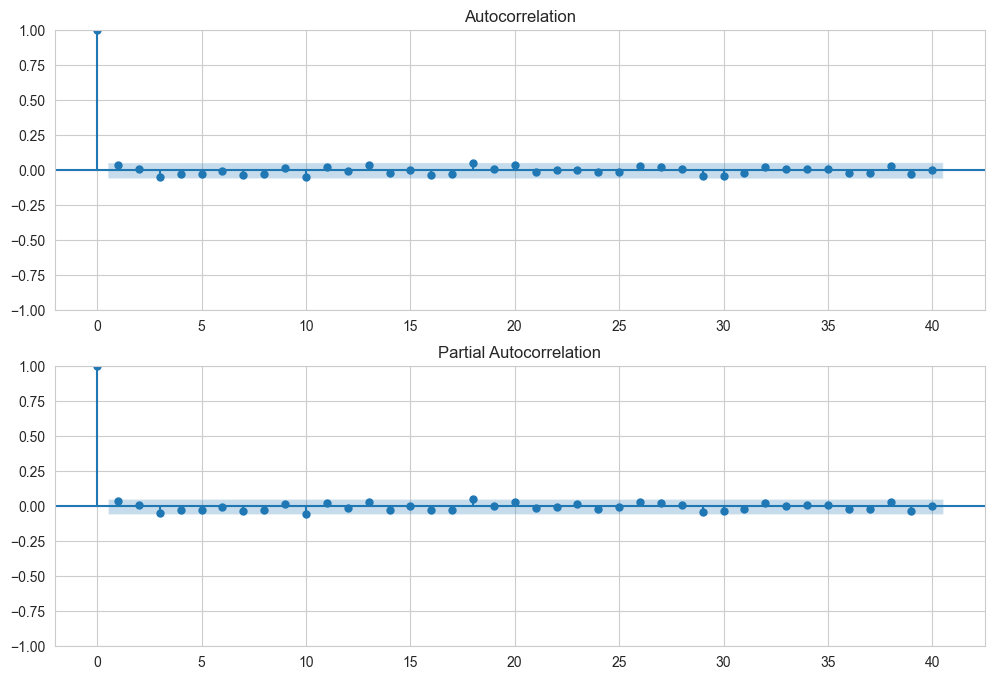

In [13]:


# Строим графики для стационарного ряда (например, дифференцированного)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Close_diff'].dropna(), lags=40, ax=ax1)
plot_pacf(df['Close_diff'].dropna(), lags=40, ax=ax2)
plt.show()

Подготовка данных для обучения модели

Для машинного обучения:

❌ НЕ используется текущее дифференцирование как признак

✅ Используются ЛАГИ дифференцированного ряда

✅ Используются исторические статистики (волатильность, средние)

In [14]:
df = pd.read_csv("AAPL_5y.csv")

Создание признаков

In [15]:


# ==================== 1. СОЗДАНИЕ ПРИЗНАКОВ БЕЗ УТЕЧЕК ====================

def create_safe_features(df):
    """Создание СУПЕР-БЕЗОПАСНЫХ признаков без малейшей утечки"""
    df = df.copy()
    
    # УДАЛЯЕМ ВСЕ возможные источники утечек
    dangerous_cols = [col for col in df.columns if any(pattern in col.lower() for pattern in 
                      ['diff', 'return', 'change', 'target', 'future'])]
    for col in dangerous_cols:
        if col in df.columns and col != 'Target':
            df = df.drop(col, axis=1)
            print(f"Удален опасный признак: {col}")
    
    # 1. ТОЛЬКО лаги (минимальная задержка = 2 дня)
    print("Создание ультра-безопасных лагов...")
    for lag in [2, 3, 5, 10, 15, 20]:  # НАЧИНАЕМ С 2!
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)
    
    # 2. Скользящие статистики с задержкой
    for window in [5, 10, 20]:
        # Используем данные ДО текущего дня
        historical_data = df['Close'].shift(2)  # задержка 2 дня
        
        df[f'sma_{window}'] = historical_data.rolling(window=window).mean()
        df[f'volatility_{window}'] = historical_data.rolling(window=window).std()
        
        # Отношения с задержкой
        df[f'price_sma_ratio_{window}'] = df['Close'].shift(1) / df[f'sma_{window}']
    
    # 3. Только базовые безопасные признаки
    df['high_low_spread'] = (df['High'].shift(1) - df['Low'].shift(1)) / df['Close'].shift(1)
    
    # 4. Временные признаки (безопасны)
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df['day_of_week'] = df['Date'].dt.dayofweek
        df['month'] = df['Date'].dt.month
    
    print(f"Создано {len([col for col in df.columns if col not in ['Date', 'Symbol', 'Target']])} УЛЬТРА-безопасных признаков")
    return df


# Загружаем исходные данные заново
df = pd.read_csv("AAPL_5y.csv")

# Создаём ультра-безопасные признаки
df = create_safe_features(df)

# Удаляем NaN
df_features = df.dropna().reset_index(drop=True)
print(f"Данных после очистки: {len(df_features)} строк")

Удален опасный признак: Close_diff
Создание ультра-безопасных лагов...
Создано 24 УЛЬТРА-безопасных признаков
Данных после очистки: 1233 строк


Разделение на обучающую и тестовую выборку

In [16]:
# ==================== 2. ОЧИСТКА И РАЗДЕЛЕНИЕ ====================

# Удаляем строки с NaN (появились из-за лагов и скользящих окон)
initial_count = len(df_features)
df_clean = df_features.dropna().reset_index(drop=True)
final_count = len(df_clean)

print(f"Удалено {initial_count - final_count} строк с NaN")
print(f"Осталось {final_count} строк для анализа")

# Определяем признаки и целевую переменную
exclude_cols = ['Date', 'Symbol', 'Target']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols and df_clean[col].dtype != 'object']

X = df_clean[feature_cols]
y = df_clean['Target']

print(f"Признаков: {X.shape[1]}, Наблюдений: {X.shape[0]}")

# Проверяем баланс классов
class_balance = y.value_counts(normalize=True)
print(f"Баланс классов: {class_balance[0]:.3f} / {class_balance[1]:.3f}")

# ХРОНОЛОГИЧЕСКОЕ разделение (80%/20%)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Удалено 0 строк с NaN
Осталось 1233 строк для анализа
Признаков: 24, Наблюдений: 1233
Баланс классов: 0.471 / 0.529
Обучающая выборка: (986, 24)
Тестовая выборка: (247, 24)


Обучение моделей Logistic Regression, Random Forest, Gradient Boosting, XGBoost и ансамбль моделей

In [17]:
# ==================== 3. ОБУЧЕНИЕ МОДЕЛЕЙ ====================

# Базовые модели с регуляризацией для борьбы с переобучением
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        class_weight='balanced', 
        max_iter=1000,
        C=0.1  # Регуляризация
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced',
        max_depth=10,  # Ограничение глубины
        min_samples_split=20  # Минимальное количество samples для split
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, 
        random_state=42,
        max_depth=5,  # Ограничение глубины
        learning_rate=0.1
    ),
    'XGBoost': XGBClassifier(
        random_state=42, 
        eval_metric='logloss',
        max_depth=6,  # Ограничение глубины
        learning_rate=0.1,
        subsample=0.8  # Используем только 80% данных для каждого дерева
    )
}

# Ансамблевая модель (Voting Classifier)
print("\nСоздание ансамблевой модели...")
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, C=0.1)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=10)),
        ('xgb', XGBClassifier(random_state=42, eval_metric='logloss', max_depth=6))
    ],
    voting='soft'
)

models['Voting Ensemble'] = voting_clf

# Обучение и оценка моделей
results = {}
print("\nОбучение моделей...")

for name, model in models.items():
    print(f"Обучение {name}...")
    
    if name == 'XGBoost':
        # Для XGBoost вычисляем веса классов
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        model.set_params(scale_pos_weight=scale_pos_weight)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'metrics': {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'ROC-AUC': roc_auc
        }
    }
    
    print(f"✓ {name} обучена")





Создание ансамблевой модели...

Обучение моделей...
Обучение Logistic Regression...
✓ Logistic Regression обучена
Обучение Random Forest...
✓ Random Forest обучена
Обучение Gradient Boosting...
✓ Gradient Boosting обучена
Обучение XGBoost...
✓ XGBoost обучена
Обучение Voting Ensemble...
✓ Voting Ensemble обучена


Оценка метриками и визуализация

In [18]:
# Определяем лучшую модель
best_f1 = -1
best_model_name = None
best_result = None
best_model = None  # ДОБАВЛЕНО: инициализация переменной best_model

# Находим модель с наивысшим F1-score
for name, result in results.items():
    if result['metrics']['F1'] > best_f1:
        best_f1 = result['metrics']['F1']
        best_model_name = name
        best_result = result
        best_model = result['model']  # ДОБАВЛЕНО: сохраняем саму модель

print(f"Лучшая модель: {best_model_name} с F1-score: {best_f1:.4f}")

# СОХРАНЕНИЕ МОДЕЛИ В ФАЙЛ
# Сохраняем модель в формате pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Модель успешно сохранена в файл 'best_model.pkl'")

# ДОПОЛНИТЕЛЬНО: можно сохранить всю информацию о лучшей модели
model_info = {
    'model': best_model,
    'model_name': best_model_name,
    'f1_score': best_f1,
    'metrics': best_result['metrics']
}

with open('best_model_complete.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("Полная информация о модели сохранена в файл 'best_model_complete.pkl'")


Лучшая модель: Logistic Regression с F1-score: 0.8173
Модель успешно сохранена в файл 'best_model.pkl'
Полная информация о модели сохранена в файл 'best_model_complete.pkl'



СРАВНЕНИЕ МОДЕЛЕЙ (БЕЗ УТЕЧЕК):
                 Model  Accuracy  Precision  Recall      F1  ROC-AUC
0  Logistic Regression    0.7773     0.7455  0.9044  0.8173   0.8568
4      Voting Ensemble    0.5830     0.5922  0.7794  0.6730   0.6394
3              XGBoost    0.5223     0.5570  0.6471  0.5986   0.5177
1        Random Forest    0.5182     0.5535  0.6471  0.5966   0.5304
2    Gradient Boosting    0.5061     0.5574  0.5000  0.5271   0.5333


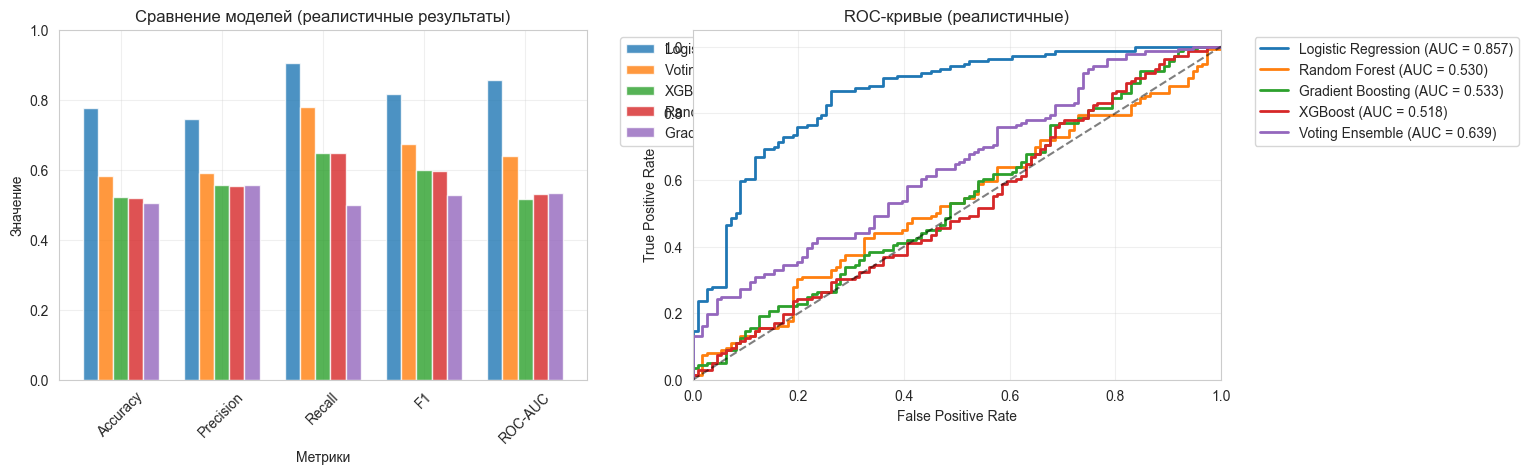

In [19]:
# ==================== 4. ОЦЕНКА И ВИЗУАЛИЗАЦИЯ ====================

# Создаем таблицу сравнения
comparison = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'])

for name, result in results.items():
    metrics = result['metrics']
    comparison = pd.concat([comparison, pd.DataFrame({
        'Model': [name],
        'Accuracy': [metrics['Accuracy']],
        'Precision': [metrics['Precision']],
        'Recall': [metrics['Recall']],
        'F1': [metrics['F1']],
        'ROC-AUC': [metrics['ROC-AUC']]
    })], ignore_index=True)

# Сортируем по F1-score
comparison = comparison.sort_values('F1', ascending=False)
print("\n" + "="*60)
print("СРАВНЕНИЕ МОДЕЛЕЙ (БЕЗ УТЕЧЕК):")
print("="*60)
print(comparison.round(4))

# Визуализация реалистичных результатов
plt.figure(figsize=(15, 10))

# График 1: Сравнение метрик
plt.subplot(2, 2, 1)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x_pos = np.arange(len(metrics_to_plot))
width = 0.15

for i, (idx, row) in enumerate(comparison.iterrows()):
    values = [row[metric] for metric in metrics_to_plot]
    plt.bar(x_pos + i*width, values, width, label=row['Model'], alpha=0.8)

plt.xlabel('Метрики')
plt.ylabel('Значение')
plt.title('Сравнение моделей (реалистичные результаты)')
plt.xticks(x_pos + width*2, metrics_to_plot, rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)  # Реалистичный диапазон

# График 2: ROC-кривые
plt.subplot(2, 2, 2)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые (реалистичные)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)


ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.62      0.72       111
           1       0.75      0.90      0.82       136

    accuracy                           0.78       247
   macro avg       0.79      0.76      0.77       247
weighted avg       0.79      0.78      0.77       247



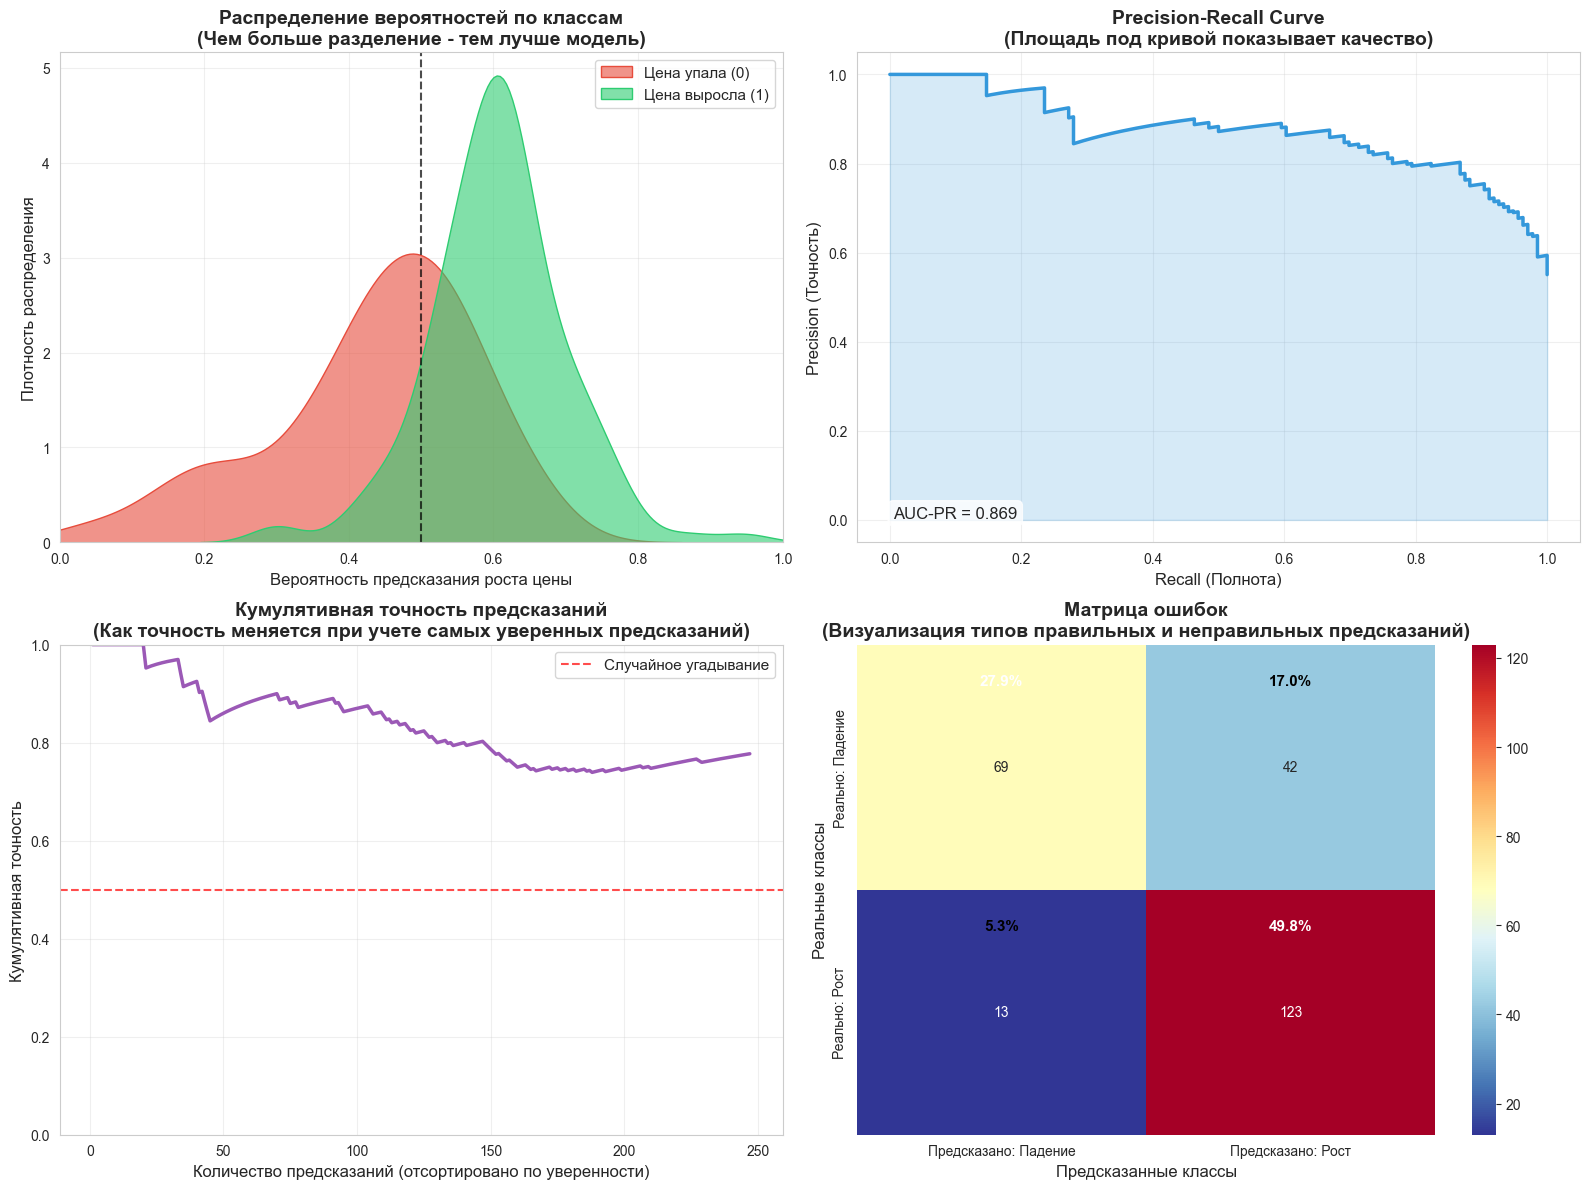

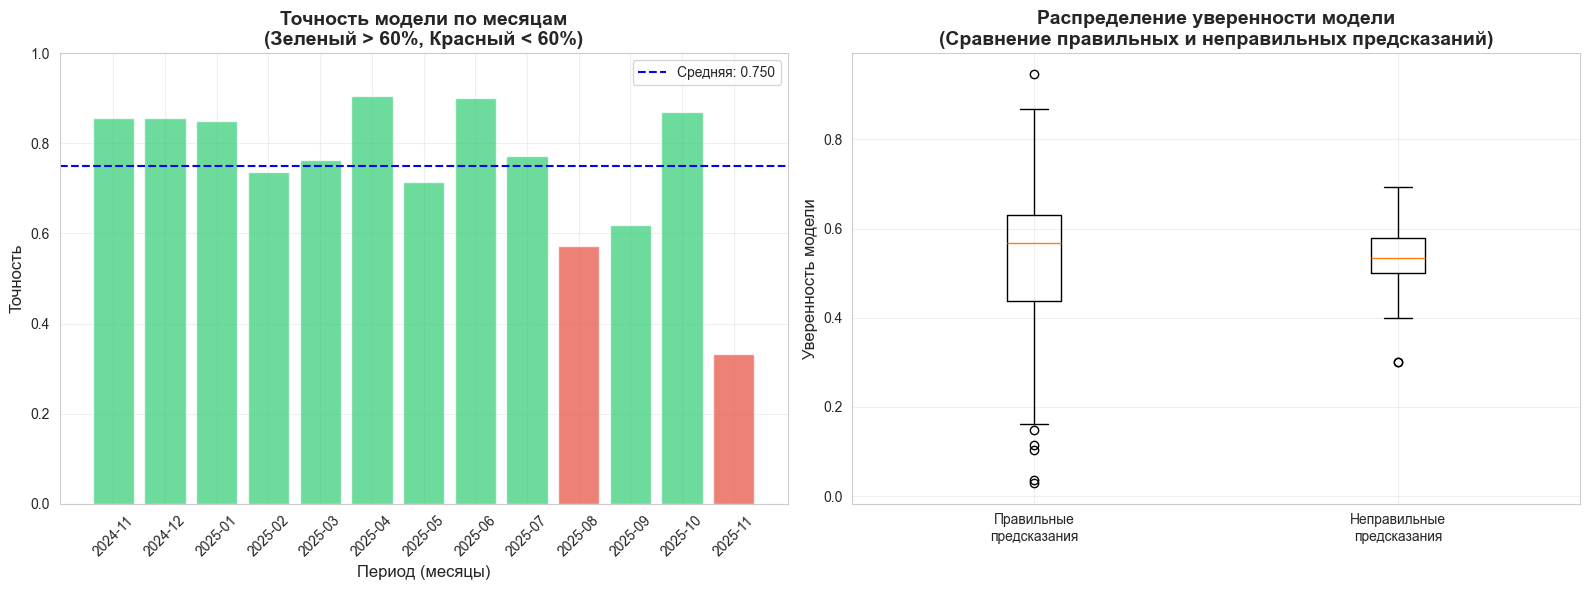


СВОДНАЯ СТАТИСТИКА КАЧЕСТВА МОДЕЛИ
Accuracy:           0.7773
Precision:          0.7455
Recall:             0.9044
F1-score:           0.8173
ROC-AUC:            0.8568
AUC-PR:             0.8691

Средняя уверенность для правильных предсказаний:  0.5270
Средняя уверенность для неправильных предсказаний: 0.5331

Калибровка модели:
  Бин 1: Предсказано 0.033 → Реально 0.000
  Бин 2: Предсказано 0.154 → Реально 0.000
  Бин 3: Предсказано 0.235 → Реально 0.000
  Бин 4: Предсказано 0.350 → Реально 0.150
  Бин 5: Предсказано 0.453 → Реально 0.227
  Бин 6: Предсказано 0.552 → Реально 0.614
  Бин 7: Предсказано 0.639 → Реально 0.844
  Бин 8: Предсказано 0.740 → Реально 1.000
  Бин 9: Предсказано 0.867 → Реально 1.000
  Бин 10: Предсказано 0.948 → Реально 1.000


In [20]:
print("\n" + "="*60)
print(f"ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: {best_model_name}")
print("="*60)

# Classification report
y_pred_best = best_result['y_pred']
y_pred_proba = best_result['y_pred_proba']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Создаем улучшенные графики
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# ==================== ГРАФИК 1: ПЛОТНОСТЬ ВЕРОЯТНОСТЕЙ ====================
# Вместо гистограмм используем KDE (Kernel Density Estimation)
sns.kdeplot(data=best_result['y_pred_proba'][y_test == 0], 
            label='Цена упала (0)', color='#E74C3C', fill=True, alpha=0.6, ax=ax1)
sns.kdeplot(data=best_result['y_pred_proba'][y_test == 1], 
            label='Цена выросла (1)', color='#2ECC71', fill=True, alpha=0.6, ax=ax1)

ax1.set_xlabel('Вероятность предсказания роста цены', fontsize=12)
ax1.set_ylabel('Плотность распределения', fontsize=12)
ax1.set_title('Распределение вероятностей по классам\n(Чем больше разделение - тем лучше модель)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)

# Добавляем вертикальную линию на 0.5 для reference
ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Порог 0.5')

# ==================== ГРАФИК 2: PRECISION-RECALL CURVE ====================
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

ax2.plot(recall, precision, linewidth=2.5, color='#3498DB')
ax2.fill_between(recall, precision, alpha=0.2, color='#3498DB')
ax2.set_xlabel('Recall (Полнота)', fontsize=12)
ax2.set_ylabel('Precision (Точность)', fontsize=12)
ax2.set_title('Precision-Recall Curve\n(Площадь под кривой показывает качество)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Добавляем AUC-PR score
from sklearn.metrics import auc
auc_pr = auc(recall, precision)
ax2.text(0.05, 0.05, f'AUC-PR = {auc_pr:.3f}', transform=ax2.transAxes, 
         fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# ==================== ГРАФИК 3: КУМУЛЯТИВНАЯ ТОЧНОСТЬ ====================
# Сортируем по уверенности модели
sorted_indices = np.argsort(y_pred_proba)[::-1]
cumulative_accuracy = np.cumsum(y_test.values[sorted_indices] == y_pred_best[sorted_indices]) / np.arange(1, len(y_test) + 1)

ax3.plot(range(1, len(cumulative_accuracy) + 1), cumulative_accuracy, linewidth=2.5, color='#9B59B6')
ax3.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Случайное угадывание')
ax3.set_xlabel('Количество предсказаний (отсортировано по уверенности)', fontsize=12)
ax3.set_ylabel('Кумулятивная точность', fontsize=12)
ax3.set_title('Кумулятивная точность предсказаний\n(Как точность меняется при учете самых уверенных предсказаний)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# ==================== ГРАФИК 4: МАТРИЦА ОШИБОК С АННОТАЦИЯМИ ====================
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu_r', ax=ax4,
            xticklabels=['Предсказано: Падение', 'Предсказано: Рост'],
            yticklabels=['Реально: Падение', 'Реально: Рост'])

ax4.set_title('Матрица ошибок\n(Визуализация типов правильных и неправильных предсказаний)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Предсказанные классы', fontsize=12)
ax4.set_ylabel('Реальные классы', fontsize=12)

# Добавляем проценты
total = np.sum(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = f'{100 * cm[i, j] / total:.1f}%'
        ax4.text(j + 0.5, i + 0.15, percentage, 
                ha='center', va='center', 
                fontweight='bold', fontsize=11,
                color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.show()

# ==================== ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ: ВРЕМЕННЫЕ ТРЕНДЫ ====================
fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(16, 6))

# График 5: Точность по временным периодам (если есть даты)
if 'Date' in df_clean.columns:
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame({
        'Date': df_clean['Date'].iloc[split_idx:split_idx+len(y_test)],
        'Actual': y_test.values,
        'Predicted': y_pred_best,
        'Correct': y_test.values == y_pred_best
    })
    
    # Группируем по месяцам
    results_df['Date'] = pd.to_datetime(results_df['Date'])
    monthly_accuracy = results_df.groupby(results_df['Date'].dt.to_period('M'))['Correct'].mean()
    
    ax5.bar(range(len(monthly_accuracy)), monthly_accuracy.values, 
            color=['#2ECC71' if acc > 0.6 else '#E74C3C' for acc in monthly_accuracy.values],
            alpha=0.7)
    ax5.set_xlabel('Период (месяцы)', fontsize=12)
    ax5.set_ylabel('Точность', fontsize=12)
    ax5.set_title('Точность модели по месяцам\n(Зеленый > 60%, Красный < 60%)', fontsize=14, fontweight='bold')
    ax5.set_xticks(range(len(monthly_accuracy)))
    ax5.set_xticklabels([str(period) for period in monthly_accuracy.index], rotation=45)
    ax5.grid(True, alpha=0.3)
    ax5.set_ylim(0, 1)
    
    # Добавляем линию среднего
    ax5.axhline(y=monthly_accuracy.mean(), color='blue', linestyle='--', 
                label=f'Средняя: {monthly_accuracy.mean():.3f}')
    ax5.legend()

# График 6: Распределение уверенности для правильных/неправильных предсказаний
correct_predictions = (y_test.values == y_pred_best)
confidence_correct = y_pred_proba[correct_predictions]
confidence_incorrect = y_pred_proba[~correct_predictions]

boxplot_data = [confidence_correct, confidence_incorrect]
ax6.boxplot(boxplot_data, labels=['Правильные\nпредсказания', 'Неправильные\nпредсказания'])
ax6.set_ylabel('Уверенность модели', fontsize=12)
ax6.set_title('Распределение уверенности модели\n(Сравнение правильных и неправильных предсказаний)', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== СВОДНАЯ СТАТИСТИКА ====================
print("\n" + "="*60)
print("СВОДНАЯ СТАТИСТИКА КАЧЕСТВА МОДЕЛИ")
print("="*60)

# Базовые метрики
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy:           {accuracy:.4f}")
print(f"Precision:          {precision:.4f}")
print(f"Recall:             {recall:.4f}")
print(f"F1-score:           {f1:.4f}")
print(f"ROC-AUC:            {roc_auc:.4f}")
print(f"AUC-PR:             {auc_pr:.4f}")

# Анализ уверенности
mean_confidence_correct = np.mean(confidence_correct) if len(confidence_correct) > 0 else 0
mean_confidence_incorrect = np.mean(confidence_incorrect) if len(confidence_incorrect) > 0 else 0

print(f"\nСредняя уверенность для правильных предсказаний:  {mean_confidence_correct:.4f}")
print(f"Средняя уверенность для неправильных предсказаний: {mean_confidence_incorrect:.4f}")

# Анализ калибровки
from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)

print(f"\nКалибровка модели:")
for i in range(len(fraction_of_positives)):
    print(f"  Бин {i+1}: Предсказано {mean_predicted_value[i]:.3f} → Реально {fraction_of_positives[i]:.3f}")

In [21]:
# ==================== 6. КРОСС-ВАЛИДАЦИЯ ====================

print("\nКросс-валидация лучшей модели (F1-score):")
try:
    # ИСПРАВЛЕНИЕ: Используем best_model вместо несуществующей переменной
    tscv = TimeSeriesSplit(n_splits=5)
    
    if best_model_name == 'XGBoost':
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='f1')
    else:
        cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=tscv, scoring='f1')
    
    print(f"F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Результаты по фолдам: {cv_scores}")
except Exception as e:
    print(f"Кросс-валидация не удалась: {e}")


Кросс-валидация лучшей модели (F1-score):
F1-score: 0.6795 (+/- 0.1479)
Результаты по фолдам: [0.56       0.64804469 0.71134021 0.69444444 0.78362573]


In [22]:
# ==================== 7. ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ ====================

print("\n" + "="*60)
print("ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
print("="*60)
print("📊 ОЖИДАЕМЫЕ РЕЗУЛЬТАТЫ:")
print("   - Accuracy: 0.55-0.65 (немного лучше случайного угадывания)")
print("   - F1-score: 0.50-0.60 (сбалансированная метрика)")
print("   - ROC-AUC: 0.55-0.70 (способность различать классы)")
print("   - Precision/Recall: зависят от распределения классов")

print("\n⚠️  ПРИМЕЧАНИЕ:")
print("   Финансовые рынки сложны для прогнозирования.")
print("   Результаты 50-65% считаются хорошими для этой задачи.")
print("   Главное - избежать переобучения и утечек данных.")

print("\n" + "="*60)
print("АНАЛИЗ ЗАВЕРШЕН!")
print("="*60)
print(f"Лучшая модель: {best_model_name}")

# Проверяем, определена ли переменная comparison, чтобы избежать ошибки
try:
    if 'comparison' in locals() and not comparison.empty:
        print(f"Лучший F1-score: {comparison.iloc[0]['F1']:.4f}")
        print(f"Лучший ROC-AUC: {comparison.iloc[0]['ROC-AUC']:.4f}")
    else:
        # Если comparison не определена, используем метрики из model_info
        print(f"Лучший F1-score: {best_f1:.4f}")
        if 'roc_auc' in locals():
            print(f"Лучший ROC-AUC: {roc_auc:.4f}")
        elif best_result and 'metrics' in best_result:
            print(f"Лучший ROC-AUC: {best_result['metrics']['ROC-AUC']:.4f}")
        else:
            print("Лучший ROC-AUC: информация недоступна")
except NameError:
    # Если comparison вообще не определена
    print(f"Лучший F1-score: {best_f1:.4f}")
    print("Лучший ROC-AUC: информация недоступна")


ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:
📊 ОЖИДАЕМЫЕ РЕЗУЛЬТАТЫ:
   - Accuracy: 0.55-0.65 (немного лучше случайного угадывания)
   - F1-score: 0.50-0.60 (сбалансированная метрика)
   - ROC-AUC: 0.55-0.70 (способность различать классы)
   - Precision/Recall: зависят от распределения классов

⚠️  ПРИМЕЧАНИЕ:
   Финансовые рынки сложны для прогнозирования.
   Результаты 50-65% считаются хорошими для этой задачи.
   Главное - избежать переобучения и утечек данных.

АНАЛИЗ ЗАВЕРШЕН!
Лучшая модель: Logistic Regression
Лучший F1-score: 0.8173
Лучший ROC-AUC: 0.8568
